# Mistral Code Embedding and Retrieval Evaluation

This notebook demonstrates a pipeline for code embedding, chunking, indexing, retrieval, and evaluation using the Mistral API, FAISS, and the SWE-bench Lite dataset.  

It uses the Mistral code embedding model `codestral-embed` to generate code embeddings and FAISS for fast similarity search. The workflow includes flattening repository structures, chunking code files into smaller segments, and generating embeddings for each chunk. These embeddings are indexed to enable efficient retrieval of relevant code snippets in response to user queries. The notebook evaluates retrieval performance on the SWE-bench Lite dataset, using recall metrics to measure effectiveness. This methodology is especially valuable for applications such as code search, code comprehension, and automated software maintenance.


## Environment Setup
Install required packages for code embedding, retrieval, and dataset handling.

In [ ]:
!pip install -q faiss-cpu mistralai mistral-common datasets fsspec==2023.9.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.4/173.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 372.3/372.3 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 32.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nv

## Imports and Tokenizer Initialization

Import necessary libraries and initialize the tokenizer for code embedding.

In [ ]:
import json
import os
import pickle
from pathlib import Path
from typing import Dict, List, Tuple, Set, Optional, Any
import numpy as np
from tqdm import tqdm
from datasets import load_dataset
from mistralai import Mistral
from langchain.text_splitter import Language, RecursiveCharacterTextSplitter
import faiss
from collections import defaultdict
import re
from getpass import getpass

from huggingface_hub import hf_hub_download
from mistral_common.tokens.tokenizers.tekken import Tekkenizer

# Download tokenizer from Hugging Face
repo_id = "mistralai/Mistral-Small-3.1-24B-Base-2503"
# adjust filename if the repo uses a different .json name
tk_path = hf_hub_download(repo_id, filename="tekken.json")

tokenizer = Tekkenizer.from_file(tk_path)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


tekken.json:   0%|          | 0.00/14.8M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/mistral_common/tokens/tokenizers/tekken.py:184: FutureWarning: Special tokens not found in /root/.cache/huggingface/hub/models--mistralai--Mistral-Small-3.1-24B-Base-2503/snapshots/db7c968753c07380364d963090b5cf8cc131a0c3/tekken.json and default to ({'rank': 0, 'token_str': <SpecialTokens.unk: '<unk>'>, 'is_control': True}, {'rank': 1, 'token_str': <SpecialTokens.bos: '<s>'>, 'is_control': True}, {'rank': 2, 'token_str': <SpecialTokens.eos: '</s>'>, 'is_control': True}, {'rank': 3, 'token_str': <SpecialTokens.begin_inst: '[INST]'>, 'is_control': True}, {'rank': 4, 'token_str': <SpecialTokens.end_inst: '[/INST]'>, 'is_control': True}, {'rank': 5, 'token_str': <SpecialTokens.begin_tools: '[AVAILABLE_TOOLS]'>, 'is_control': True}, {'rank': 6, 'token_str': <SpecialTokens.end_tools: '[/AVAILABLE_TOOLS]'>, 'is_control': True}, {'rank': 7, 'token_str': <SpecialTokens.begin_tool_results: '[TOOL_RESULTS]'>, 'is_control': True}, {'rank': 8, 'token_str': <S

## API Key Setup
Set up your Mistral API key for authentication.

In [ ]:
api_key = getpass("Enter your MISTRAL_API_KEY: ").strip()
os.environ["MISTRAL_API_KEY"] = api_key


client = Mistral(api_key=api_key.strip())

Enter your MISTRAL_API_KEY: ··········


## Embedding and Chunking Configuration
Define parameters for code embedding and chunking.

In [ ]:
# embeddings
TOP_K = 5
EMBED_MODEL = "codestral-embed"
MAX_BATCH_SIZE = 128  # for embedding
MAX_TOTAL_TOKENS = 16384  # for embedding
MAX_SEQUENCE_LENGTH = 8192  # for embedding

# chunking
DO_CHUNKING = True
CHUNK_SIZE = 3000
CHUNK_OVERLAP = 1000

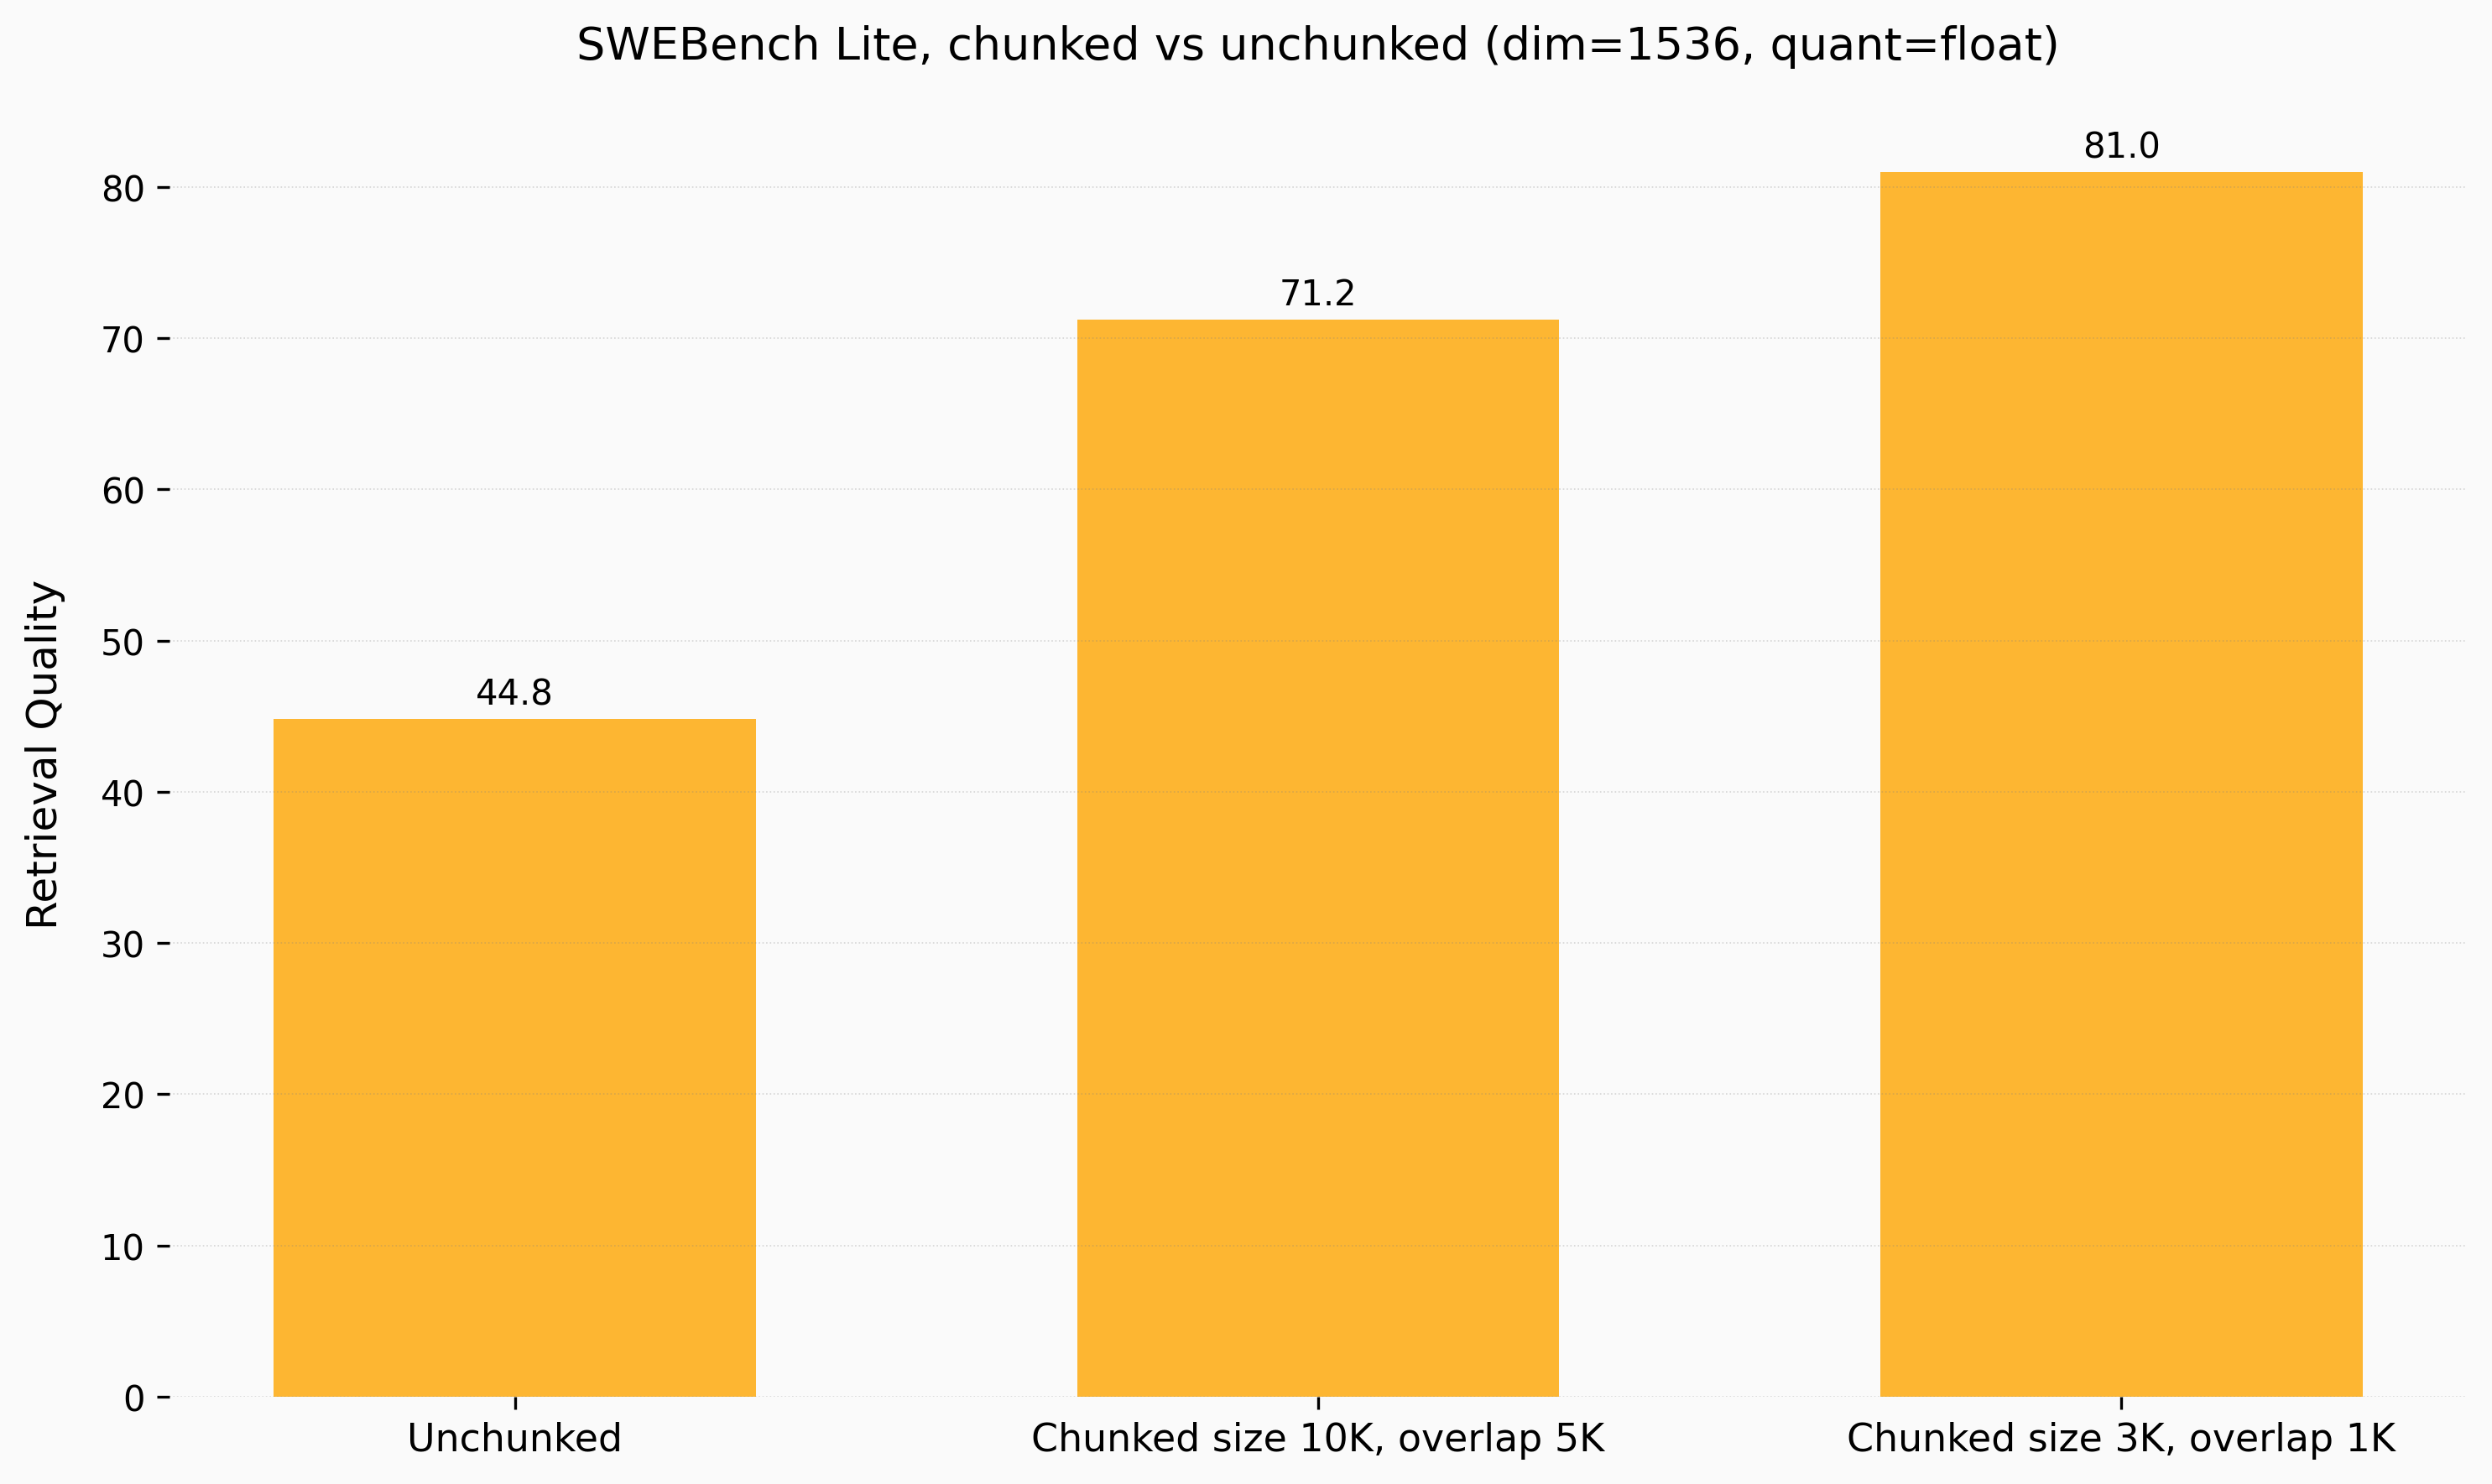

In our experiments, we find that chunking with small chunk size (3000 characters, ~512 tokens) and overlap (1000 characters), leads to much better retrieval for RAG.


## Download and Prepare Repository Structures

Download and extract repository structures for the SWE-bench Lite dataset.

In [ ]:
import gdown
import zipfile

USE_MIN_SWEBENCH = True

if not USE_MIN_SWEBENCH:
  # for all 300 repo_structures from Agentless for swebench lite - https://github.com/OpenAutoCoder/Agentless/blob/main/README_swebench.md#-setup
  zip_url = "https://drive.google.com/uc?id=15-4XjTmY48ystrsc_xcvtOkMs3Fx8RoW"
  zip_path = "/content/swebench_repo_structure.zip"
  repo_structures_path = "/content/repo_structures/repo_structures"

else:
  # subset of 33 tasks from above for faster download
  zip_url = "https://drive.google.com/uc?id=1wG1CcfVHi-70FoAd5wPI59WdI4g1LkpS"
  zip_path = "/content/min_swebench_repo_structure.zip"
  repo_structures_path = "/content/min_repo_structures/repo_structures"

if not os.path.exists(repo_structures_path):
  gdown.download(zip_url, zip_path, quiet=False)

  with zipfile.ZipFile(zip_path, 'r') as zip_ref:
      zip_ref.extractall("/content/")

# Set paths
index_dir: str = "/content/swebench_indexes"
results_file: str = "/content/swebench_results.json"

if DO_CHUNKING:
    # make swebench_indexes to swebench_indexes_chunked_<chunk_size>_<chunk_overlap>
    index_dir = f"{index_dir}_chunked_size_{CHUNK_SIZE}_overlap_{CHUNK_OVERLAP}"
    Path(index_dir).mkdir(exist_ok=True)

# Create index directory
Path(index_dir).mkdir(exist_ok=True)

Downloading...
From (original): https://drive.google.com/uc?id=1wG1CcfVHi-70FoAd5wPI59WdI4g1LkpS
From (redirected): https://drive.google.com/uc?id=1wG1CcfVHi-70FoAd5wPI59WdI4g1LkpS&confirm=t&uuid=ff0d2b10-c817-4e53-abd5-44d7755dd926
To: /content/min_swebench_repo_structure.zip
100%|██████████| 200M/200M [00:01<00:00, 139MB/s]


## Utility Functions for Data Processing

Define helper functions for flattening repository structures, chunking code, formatting documents, and extracting file paths from patches.

In [ ]:
def flatten_repo_structure(
    structure: Dict[str, Any], current_path: str = ""
) -> Dict[str, str]:
    """
    Recursively flatten nested repo structure into file paths and contents.
    Only keeps non-empty Python files.
    """
    flattened = {}

    for key, value in structure.items():
        # Build the path
        path = os.path.join(current_path, key) if current_path else key

        if isinstance(value, dict):
            # Check if this is a file with content
            if "text" in value and isinstance(value["text"], list):
                # This is a file with content
                content = "\n".join(value["text"])

                # Only keep Python files with non-empty content
                if path.endswith(".py") and content.strip():
                    flattened[path] = content
            else:
                # This is a directory, recurse
                flattened.update(flatten_repo_structure(value, path))

    return flattened


def load_repository_structure(
    repo_structures_path: str, instance_id: str
) -> Dict[str, str]:
    """Load and flatten repository structure from JSON file."""
    json_path = Path(repo_structures_path) / f"{instance_id}.json"

    if not json_path.exists():
        print(f"Warning: Repository structure not found for {instance_id}")
        return {}

    with open(json_path, "r") as f:
        data = json.load(f)

    # The structure is usually under a "structure" key with the repo name
    if "structure" in data:
        structure = data["structure"]
        # Get the first (and usually only) key which is the repo name
        # repo_name = list(structure.keys())[0] if structure else ""
        # if repo_name:
        #     structure = structure[repo_name]

        # Flatten the structure
        return flatten_repo_structure(structure)

    # Fallback: assume the entire JSON is the structure
    return flatten_repo_structure(data)


def get_language_from_path(path: str) -> Optional[Language]:
    """Get language from file extension."""
    EXTENSION_TO_LANGUAGE = {
        ".cpp": Language.CPP,
        ".cc": Language.CPP,
        ".cxx": Language.CPP,
        ".c++": Language.CPP,
        ".go": Language.GO,
        ".java": Language.JAVA,
        ".kt": Language.KOTLIN,
        ".kts": Language.KOTLIN,
        ".js": Language.JS,
        ".mjs": Language.JS,
        ".ts": Language.TS,
        ".php": Language.PHP,
        ".proto": Language.PROTO,
        ".py": Language.PYTHON,
        ".pyw": Language.PYTHON,
        ".rst": Language.RST,
        ".rb": Language.RUBY,
        ".rs": Language.RUST,
        ".scala": Language.SCALA,
        ".swift": Language.SWIFT,
        ".md": Language.MARKDOWN,
        ".markdown": Language.MARKDOWN,
        ".tex": Language.LATEX,
        ".html": Language.HTML,
        ".htm": Language.HTML,
        ".sol": Language.SOL,
        ".cs": Language.CSHARP,
        ".cbl": Language.COBOL,
        ".cob": Language.COBOL,
        ".c": Language.C,
        ".h": Language.C,
        ".lua": Language.LUA,
        ".pl": Language.PERL,
        ".pm": Language.PERL,
        ".hs": Language.HASKELL,
        ".ex": Language.ELIXIR,
        ".exs": Language.ELIXIR,
        ".ps1": Language.POWERSHELL,
    }
    _, ext = os.path.splitext(path)
    return EXTENSION_TO_LANGUAGE.get(ext.lower())


def chunk_corpus(
    corpus: Dict[str, Dict[str, str]], chunk_size: int, chunk_overlap: int
) -> Dict[str, Dict[str, str]]:
    """Chunk the corpus using language-specific splitters."""
    new_corpus = {}

    for orig_id, doc in corpus.items():
        title = doc.get("title", "").strip()
        text = doc.get("text", "").strip()

        # Skip empty texts
        if not text:
            continue

        # Get language-specific splitter
        language = get_language_from_path(title)
        if language:
            try:
                splitter = RecursiveCharacterTextSplitter.from_language(
                    language=language,
                    chunk_size=chunk_size,
                    chunk_overlap=chunk_overlap,
                )
            except:
                # Fallback to generic splitter
                splitter = RecursiveCharacterTextSplitter(
                    chunk_size=chunk_size,
                    chunk_overlap=chunk_overlap,
                )
        else:
            splitter = RecursiveCharacterTextSplitter(
                chunk_size=chunk_size,
                chunk_overlap=chunk_overlap,
            )

        # Split only the text
        chunks = splitter.split_text(text)
        if not chunks:
            new_corpus[orig_id] = doc
            continue

        for i, chunk_text in enumerate(chunks):
            chunk_id = f"{orig_id}_<chunk>_{i}"
            new_corpus[chunk_id] = {
                "title": title,
                "text": chunk_text,
            }

    return new_corpus


def format_doc(doc: Dict[str, str]) -> str:
    """Format document for embedding."""
    assert "title" in doc and "text" in doc
    title = doc.get("title", "").strip()
    text = doc.get("text", "").strip()
    return f"{title}\n{text}" if title else text


def get_embeddings_batch(texts: List[str]) -> List[List[float]]:
    """Get embeddings for a batch of texts using Mistral API with token limits."""
    if not texts:
        return []


    # Filter texts by token count and prepare batches
    valid_texts = []
    for text in texts:
        tokens = tokenizer.encode(text, bos=False, eos=False)
        if len(tokens) <= MAX_SEQUENCE_LENGTH:  # Max tokens per individual text
            valid_texts.append(text)
        else:
            # Truncate text instead of skipping
            truncated_tokens = tokens[:MAX_SEQUENCE_LENGTH]
            truncated_text = tokenizer.decode(truncated_tokens)
            valid_texts.append(truncated_text)
            print(
                f"Truncated text from {len(tokens)} to {len(truncated_tokens)} tokens"
            )

    if not valid_texts:
        return []

    # Create batches respecting token and size limits
    batches = []
    current_batch = []
    current_batch_tokens = 0

    for text in valid_texts:
        tokens = tokenizer.encode(text, bos=False, eos=False)
        text_token_count = len(tokens)

        # Check if adding this text would exceed limits
        if (len(current_batch) >= MAX_BATCH_SIZE or  # Max batch size
            current_batch_tokens + text_token_count > MAX_TOTAL_TOKENS):  # Max total tokens

            if current_batch:
                batches.append(current_batch)
                current_batch = []
                current_batch_tokens = 0

        current_batch.append(text)
        current_batch_tokens += text_token_count

    # Add the last batch if it's not empty
    if current_batch:
        batches.append(current_batch)

    # Process batches
    all_embeddings = []
    for batch in tqdm(batches, desc="Processing embedding batches"):
        try:
            response = client.embeddings.create(
                model=EMBED_MODEL,
                inputs=batch,
            )
            batch_embeddings = [data.embedding for data in response.data]
            all_embeddings.extend(batch_embeddings)
        except Exception as e:
            print(f"Error getting embeddings for batch: {e}")
            # Add empty embeddings for failed batch
            all_embeddings.extend([[] for _ in batch])

    return all_embeddings


def parse_patch_for_files(patch: str) -> Set[str]:
    """Extract file paths from a patch."""
    files = set()

    # Look for diff headers
    diff_pattern = r"^diff --git a/(.*?) b/(.*?)$"
    for line in patch.split("\n"):
        match = re.match(diff_pattern, line)
        if match:
            # Usually both paths are the same, but take both just in case
            files.add(match.group(1))
            files.add(match.group(2))

    # Also look for --- and +++ lines
    file_pattern = r"^[\-\+]{3} [ab]/(.*?)(?:\s|$)"
    for line in patch.split("\n"):
        match = re.match(file_pattern, line)
        if match and match.group(1) != "/dev/null":
            files.add(match.group(1))

    return files


def load_swebench_lite():
    """Load SWE-bench Lite dataset and extract ground truth."""
    print("Loading SWE-bench Lite dataset...")
    dataset = load_dataset("princeton-nlp/SWE-bench_Lite", split="test", download_mode="force_redownload")

    ground_truth_dict = {}
    instances = []

    for item in dataset:
        instance_id = item["instance_id"]
        problem_statement = item["problem_statement"]
        patch = item["patch"]

        # Extract files from patch
        files_changed = parse_patch_for_files(patch)

        ground_truth_dict[instance_id] = list(files_changed)
        instances.append(
            {
                "instance_id": instance_id,
                "problem_statement": problem_statement,
                "patch": patch,
                "files_changed": list(files_changed),
            }
        )

    return instances, ground_truth_dict



## Embedding, Indexing, and Retrieval Functions

Functions for generating embeddings, building FAISS indexes, retrieving relevant files, and evaluating recall.

In [ ]:


def index_repository(repo_content: Dict[str, str], instance_id: str, index_dir: str):
    """Index a repository and save the index."""
    print(f"\nIndexing repository for {instance_id}...")
    print(f"Found {len(repo_content)} Python files")

    if not repo_content:
        print(f"No Python files found for {instance_id}")
        return

    # Create corpus format expected by chunking function
    corpus = {}
    for file_path, content in repo_content.items():
        corpus[file_path] = {"title": file_path, "text": content}

    # Chunk the corpus only if DO_CHUNKING is True
    if DO_CHUNKING:
        print(f"Chunking {len(corpus)} files...")
        chunked_corpus = chunk_corpus(corpus, CHUNK_SIZE, CHUNK_OVERLAP)
        print(f"Created {len(chunked_corpus)} chunks from {len(corpus)} files (size increase: {len(chunked_corpus)/len(corpus):.1f}x)")
    else:
        print("Skipping chunking (DO_CHUNKING=False)")
        chunked_corpus = corpus

    if not chunked_corpus:
        print(f"No chunks created for {instance_id}")
        return

    # Prepare texts for embedding
    texts_to_embed = []
    chunk_ids = []
    chunk_to_file = {}  # Map chunk_id to original file path

    print("Preparing texts for embedding...")
    for chunk_id, chunk_doc in chunked_corpus.items():
        text = format_doc(chunk_doc)
        texts_to_embed.append(text)
        chunk_ids.append(chunk_id)

        # Extract original file path from chunk_id
        if DO_CHUNKING and "_<chunk>_" in chunk_id:
            original_file = chunk_id.split("_<chunk>_")[0]
        else:
            original_file = chunk_id
        chunk_to_file[chunk_id] = original_file

    # Get embeddings in batches
    print("Getting embeddings...")
    all_embeddings = get_embeddings_batch(texts_to_embed)

    if not all_embeddings or len(all_embeddings) != len(texts_to_embed):
        print(f"Failed to get embeddings for {instance_id}")
        return

    # Convert to numpy array
    print("Creating FAISS index...")
    embeddings_array = np.array(all_embeddings, dtype=np.float32)

    # Create FAISS index
    dimension = embeddings_array.shape[1]
    index = faiss.IndexFlatIP(dimension)  # Inner product for cosine similarity

    # Normalize for cosine similarity
    faiss.normalize_L2(embeddings_array)
    index.add(embeddings_array)

    # Save index and metadata
    instance_index_dir = Path(index_dir) / instance_id
    instance_index_dir.mkdir(parents=True, exist_ok=True)

    # Save FAISS index
    faiss.write_index(index, str(instance_index_dir / "index.faiss"))

    # Save metadata
    metadata = {
        "chunk_ids": chunk_ids,
        "chunk_to_file": chunk_to_file,
        "dimension": dimension,
        "num_chunks": len(chunk_ids),
        "num_files": len(corpus),
    }

    with open(instance_index_dir / "metadata.pkl", "wb") as f:
        pickle.dump(metadata, f)

    print(f"Saved index for {instance_id} with {len(chunk_ids)} chunks")


def retrieve_files(
    query: str, instance_id: str, index_dir: str, top_k: int = 5
) -> List[Tuple[str, float]]:
    """Retrieve top-k files for a query using max pooling over chunks."""
    instance_index_dir = Path(index_dir) / instance_id

    if not instance_index_dir.exists():
        print(f"Index not found for {instance_id}")
        return []

    # Load index and metadata
    index = faiss.read_index(str(instance_index_dir / "index.faiss"))
    with open(instance_index_dir / "metadata.pkl", "rb") as f:
        metadata = pickle.load(f)

    # Get query embedding
    embeddings = get_embeddings_batch([query])
    if not embeddings:
        print(f"Failed to get query embedding for {instance_id}")
        return []

    query_embedding = embeddings[0]
    query_vec = np.array(query_embedding, dtype=np.float32).reshape(1, -1)
    faiss.normalize_L2(query_vec)

    # Search for similar chunks
    k = min(100, index.ntotal)  # Get more chunks for max pooling
    distances, indices = index.search(query_vec, k)

    # Max pool by file
    file_scores = defaultdict(float)
    for idx, score in zip(indices[0], distances[0]):
        if idx < len(metadata["chunk_ids"]):
            chunk_id = metadata["chunk_ids"][idx]
            file_path = metadata["chunk_to_file"][chunk_id]
            file_scores[file_path] = max(file_scores[file_path], score)

    # Sort by score
    sorted_files = sorted(file_scores.items(), key=lambda x: x[1], reverse=True)

    return sorted_files[:top_k]


def evaluate_recall_at_k(
    retrieved_files: List[str], ground_truth_files: List[str], k: int = 5
) -> float:
    """Calculate recall@k."""
    if not ground_truth_files:
        return 0.0

    retrieved_set = set(retrieved_files[:k])
    ground_truth_set = set(ground_truth_files)

    return len(retrieved_set & ground_truth_set) / len(ground_truth_set)

## Load SWE-bench Lite Dataset

Load the SWE-bench Lite dataset and extract ground truth file changes for evaluation.

In [ ]:
"""Main evaluation pipeline."""
# Load SWE-bench Lite
instances, ground_truth_dict = load_swebench_lite()
print(f"Loaded {len(instances)} instances from SWE-bench Lite")

Loading SWE-bench Lite dataset...


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating dev split:   0%|          | 0/23 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/300 [00:00<?, ? examples/s]

Loaded 300 instances from SWE-bench Lite


## Main Evaluation Loop

For each instance in the dataset, index the repository, retrieve relevant files for the problem statement, and compute recall@5.

In [ ]:
results = []
recall_scores = []

for i, instance in enumerate(instances):
    print(f'\n\nProcessing instance {i+1} of {len(instances)}')
    instance_id = instance["instance_id"]
    problem_statement = instance["problem_statement"]
    ground_truth_files = ground_truth_dict[instance_id]

    # Skip if no ground truth files
    if not ground_truth_files:
        print(f"No ground truth files for {instance_id}, skipping...")
        continue

    # Load repository structure
    repo_content = load_repository_structure(repo_structures_path, instance_id)
    if not repo_content:
        continue

    # Index repository if not already indexed
    instance_index_dir = Path(index_dir) / instance_id
    if not instance_index_dir.exists():
        index_repository(repo_content, instance_id, index_dir)

    # Retrieve files for the problem statement
    retrieved_files = retrieve_files(
        problem_statement, instance_id, index_dir, top_k=5
    )
    retrieved_file_paths = [f[0] for f in retrieved_files]
    print(f"Retrieved files: {retrieved_file_paths}")
    print(f"Ground truth files: {ground_truth_files}")
    # Calculate recall@5
    recall_at_5 = evaluate_recall_at_k(
        retrieved_file_paths, ground_truth_files, k=5
    )
    recall_scores.append(recall_at_5)

    # Convert numpy floats to regular floats for JSON serialization
    retrieved_files_serializable = [(file_path, float(score)) for file_path, score in retrieved_files[:5]]

    # Store results
    result = {
        "instance_id": instance_id,
        "ground_truth_files": ground_truth_files,
        "retrieved_files": retrieved_files_serializable,  # Store with scores
        "recall_at_5": recall_at_5,
    }
    results.append(result)
    print(f"{instance_id}: Recall@5 = {recall_at_5:.3f}")

    # 🚨🚨🚨 - remove to evaluate on more instances 🚨🚨🚨
    break



Processing instance 1 of 300

Indexing repository for astropy__astropy-12907...
Found 872 Python files
Chunking 872 files...
Created 6660 chunks from 872 files (size increase: 7.6x)
Preparing texts for embedding...
Getting embeddings...


Processing embedding batches: 100%|██████████| 263/263 [05:22<00:00,  1.23s/it]


Creating FAISS index...
Saved index for astropy__astropy-12907 with 6660 chunks


Processing embedding batches: 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]

Retrieved files: ['astropy/modeling/separable.py', 'astropy/modeling/tests/test_separable.py', 'astropy/modeling/tests/test_models.py', 'astropy/modeling/core.py', 'astropy/modeling/tests/test_compound.py']
Ground truth files: ['astropy/modeling/separable.py']
astropy__astropy-12907: Recall@5 = 1.000


## Results and Summary

Calculate and save the average recall@5 and detailed results for all evaluated instances.

In [ ]:
# Calculate average recall
avg_recall = np.mean(recall_scores) if recall_scores else 0.0

# Save detailed results
final_results = {
    "instances": results,
    "average_recall_at_5": avg_recall,
    "num_instances": len(results),
}

with open(results_file, "w") as f:
    json.dump(final_results, f, indent=2)

print(f"\nEvaluation complete!")
print(f"Average Recall@5: {avg_recall:.3f}")
print(f"Results saved to {results_file}")


Evaluation complete!
Average Recall@5: 1.000
Results saved to /content/swebench_results.json
